In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt

from validphys.api import API
from validphys.loader import FallbackLoader

%matplotlib inline

l = FallbackLoader()

## Comparing different fits with MC uncertainties

In [3]:
def fluctuate_points_cholesky(mat, central_data, replicas=1, seed=1):
  fluctuate_points = np.zeros((central_data.size, replicas))

  # Remove zero columns and rows
  non_zero_columns = np.any(mat != 0, axis=0)
  covmat = mat[:, non_zero_columns]
  non_zero_rows = np.any(covmat != 0, axis=1)
  covmat = covmat[non_zero_rows, :]
  
  # Apply the same mask to central data
  data = central_data[non_zero_rows]

  # Compute Cholesky decomposition
  L = np.linalg.cholesky(covmat)

  # Loop over replicas
  for k in range(replicas):
    rng = np.random.default_rng(seed=seed + k)
    noise = L @ rng.normal(size=data.size)
    fluctuate_points[:, k] = central_data
    fluctuate_points[non_zero_rows, k] += noise

  return fluctuate_points

In [4]:
results_dir = "./Results"

In [6]:
fitnames = [
  "250310-ac-04-pc-low_cuts-ct",
  "250310-ac-06-pc-low_cuts-ct-nopos"
]
fit_labels = {
  fitnames[0] : r'CT',
  fitnames[1] : r'CT no pos.',
}
colors = {
  fitnames[0] : 'red',
  fitnames[1] : 'blue',
}

x_nodes = {}
posteriors_dict = {}
P_tilde_dict = {}

for fitname in fitnames:
  thcovmat_dict = API.fit(fit=fitname).as_input()["theorycovmatconfig"]
  ht_parameters = thcovmat_dict['pc_parameters']
  x_nodes_dict = defaultdict(list)
  for pc_name, pc_par in ht_parameters.items():
    x_nodes_dict[pc_name] = pc_par['nodes']
  x_nodes[fitname] = x_nodes_dict

  try:
    posteriors_dict[fitname] = pd.read_pickle(results_dir + f"/{fitname}/posteriors.pkl")
    P_tilde_dict[fitname] = pd.read_pickle(results_dir + f"/{fitname}/P_tilde.pkl")
  except FileNotFoundError as e:
    print(e)

In [7]:
save_dir = f"./Comparisons/" + "_VS_".join(fitnames)
target_dir = Path(save_dir)
if not target_dir.is_dir():
  target_dir.mkdir(parents=True, exist_ok=True)

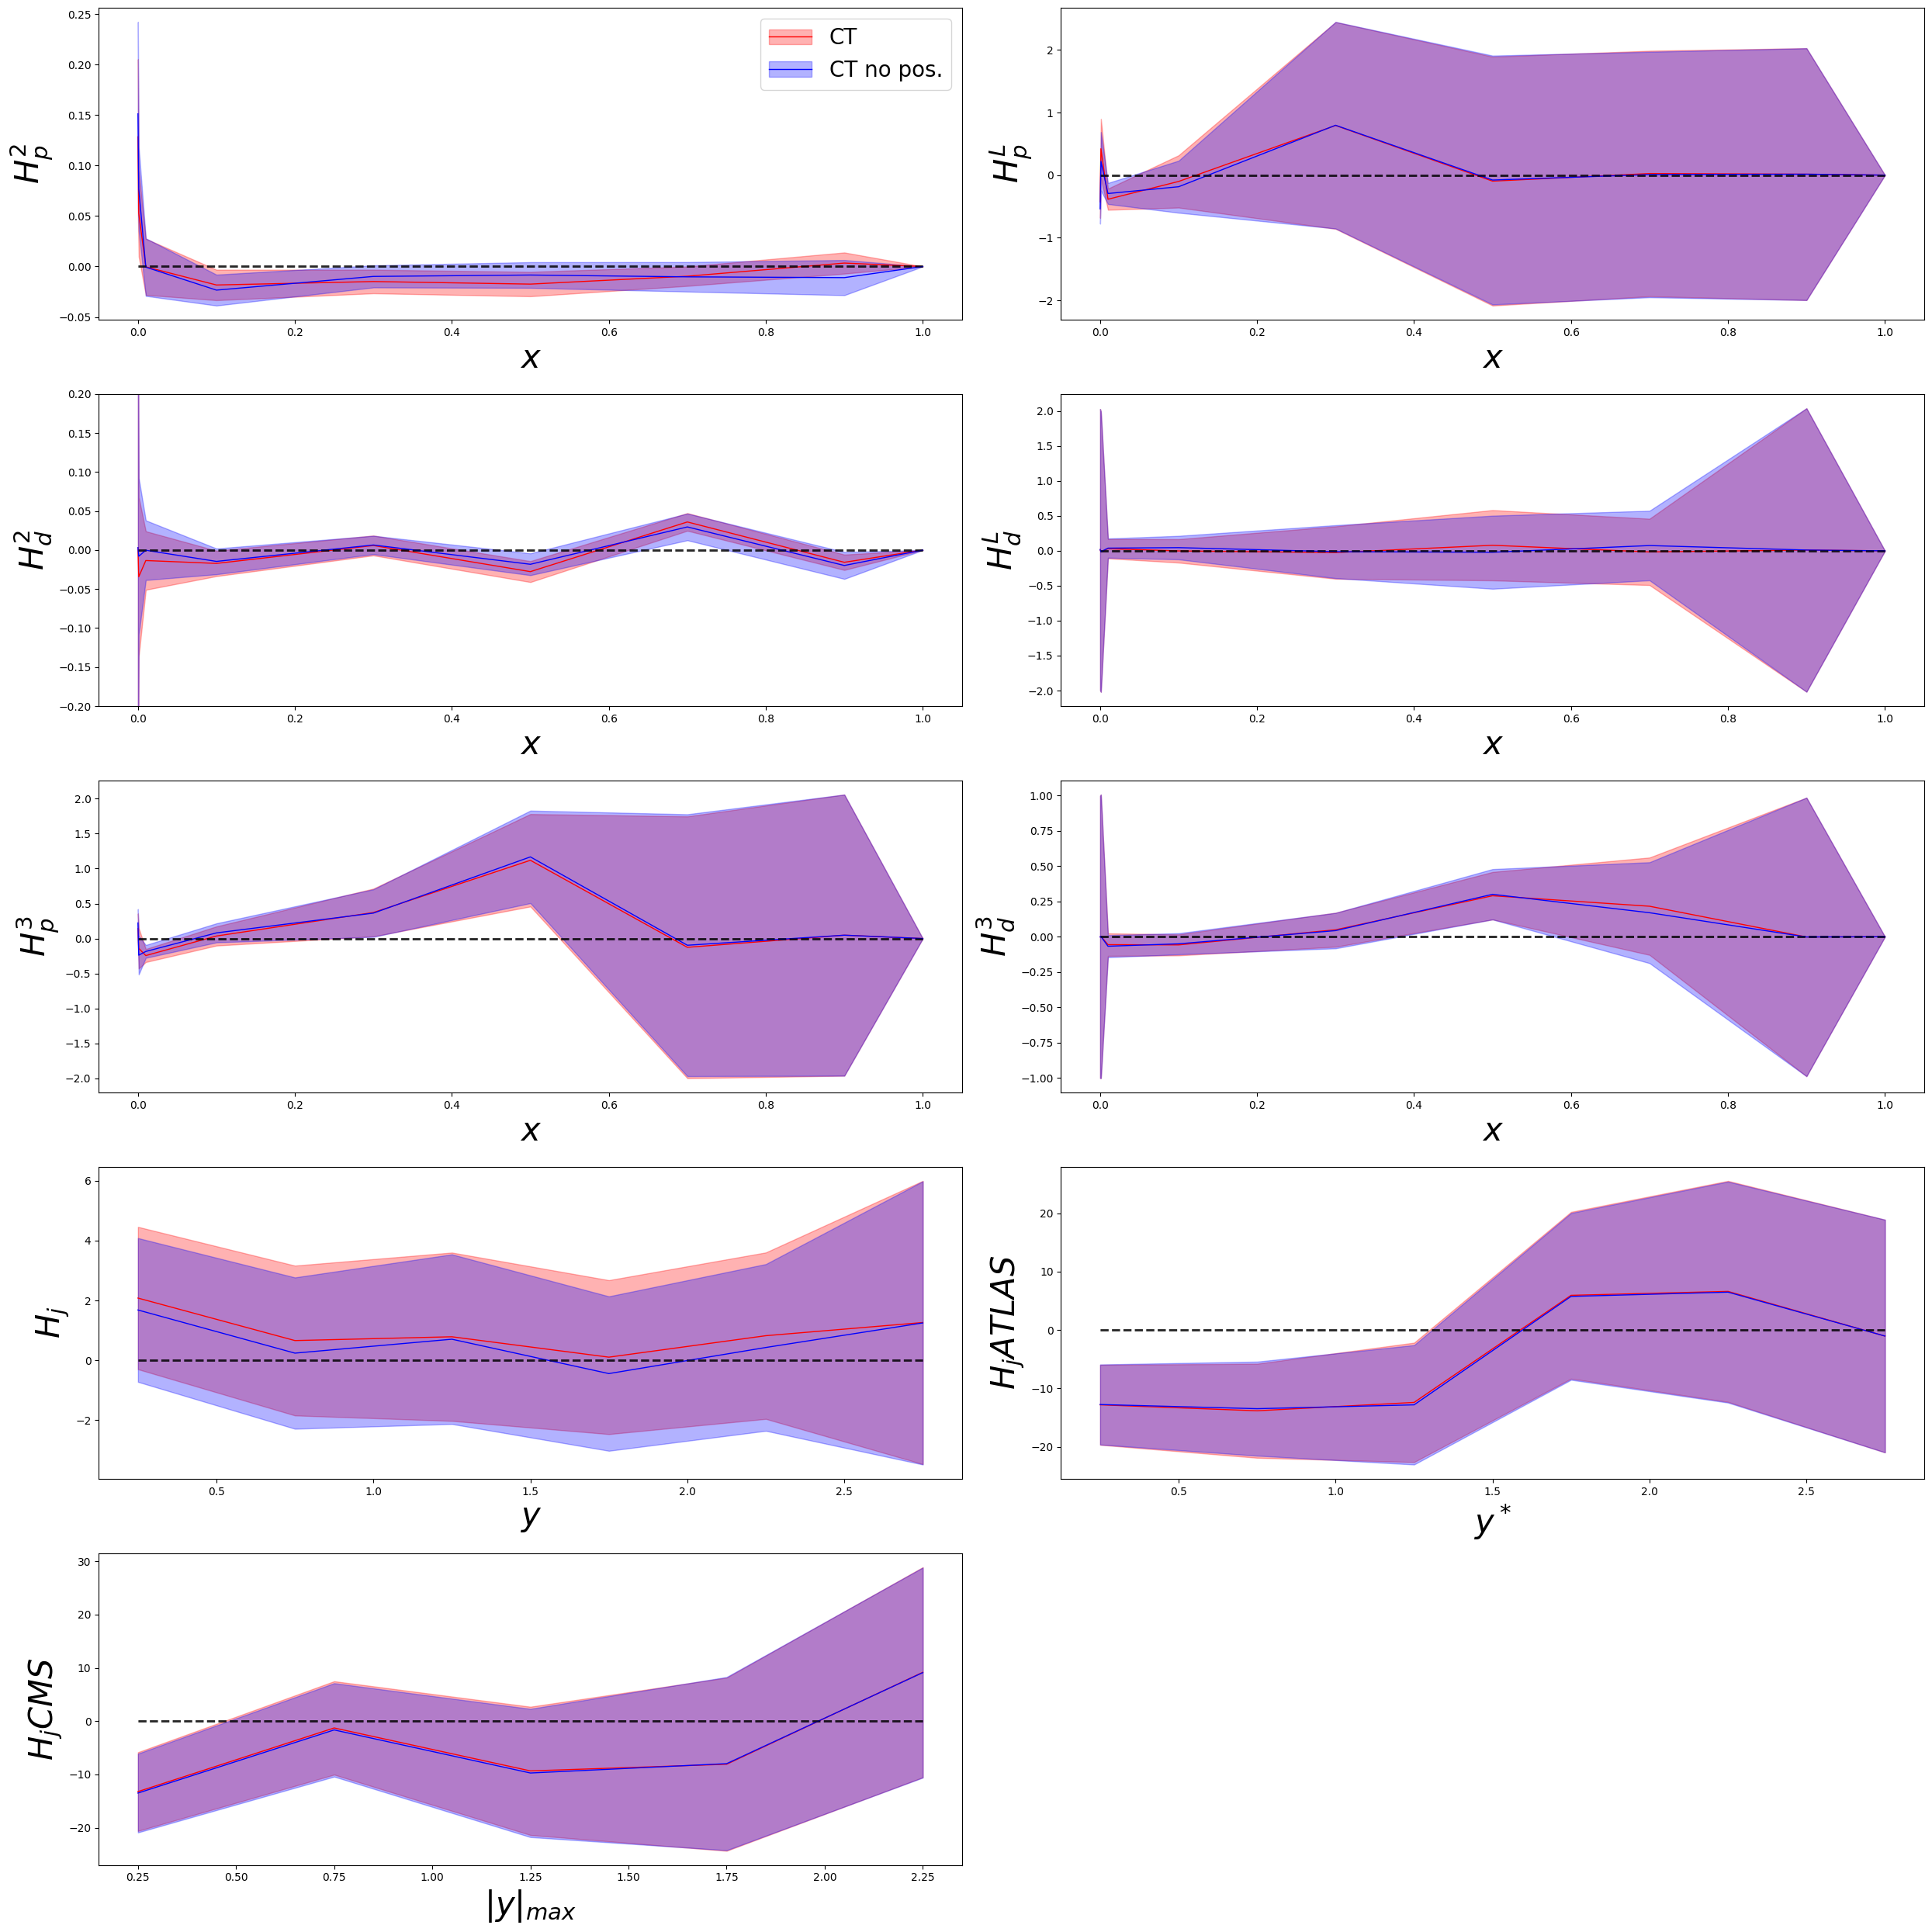

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(25, 25))
keys = ["H2p", "HLp", "H2d", "HLd", "H3p", "H3d", "Hj", "H2j_ATLAS", "H2j_CMS"]
axs[4,1].axis('off')
legends = []
legend_names = []

for fitname in fitnames:
  posteriors = posteriors_dict[fitname]
  P_tilde = P_tilde_dict[fitname]

  replicas = fluctuate_points_cholesky(P_tilde.to_numpy(), posteriors.to_numpy(), replicas=10000, seed=2143123)
  mean = pd.Series(replicas.mean(axis=1), index=posteriors.index)
  std = pd.Series(replicas.std(axis=1), index=posteriors.index)
  df_replicas = pd.DataFrame(replicas, index=posteriors.index, columns=[f"replica_{i}" for i in range(replicas.shape[1])])

  for idx_ax, (ax, key) in enumerate(zip(axs.flatten(), keys)):
    bin_edges = x_nodes[fitname][key]

    shift_central = mean.xs(level='HT', key=key).to_numpy()
    shift_std = std.xs(level='HT', key=key).to_numpy()

    # Choose the x label according to the key
    if len(key) == 3:
      ylabel = rf"$H^{key[1]}_{key[2]}$"
      xlabel = f"$x$"
    else:
      if key == "H2j_ATLAS":
        ylabel = f"$H_j ATLAS$"
        xlabel = f"$y^*$"
      elif key == "H2j_CMS":
        xlabel = f"$|y|_{{max}}$"
        ylabel = rf"$H_j CMS$"
      else:
        xlabel = f"$y$"
        ylabel = rf"$H_j$"

    # plot
    pl = ax.plot(bin_edges, shift_central, ls = "-", lw = 1, color = colors[fitname])
    pl_lg = ax.fill(np.NaN, np.NaN, alpha = 0.3, color = pl[0].get_color()) # Necessary for fancy legend
    pl_fb  = ax.fill_between(bin_edges, shift_central - shift_std, shift_central + shift_std, color = pl[0].get_color(),  alpha = 0.3)

    # Zero line
    ax.plot(bin_edges, np.zeros_like(bin_edges), ls = "dashed", lw = 2, color="black", alpha=0.6)


    # labels and scales
    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    ax.set_xscale('log')

  # Legend labels
  legends.append((pl[0], pl_lg[0]))
  legend_names.append(fit_labels[fitname])

axs[0,0].legend(legends, legend_names, loc='best', fontsize=20)
axs[1,0].set_ylim(-0.2, 0.2)

  
fig.tight_layout()
fig.savefig(save_dir + "/log_scale.png")

for ax in axs.flatten():
 ax.set_xscale('linear')

fig.tight_layout()
fig.savefig(save_dir + "/linear_scale.png")
